In [1]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Toxicity classification using Gemini fine-tuned


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
      <img src="https://avatars.githubusercontent.com/u/33467679?s=200&v=4" width="32px" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
      <img src="https://github.githubassets.com/assets/GitHub-Mark-ea2971cee799.png" width="32px" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/ai-ml-recipes/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/bigquery/import?url=https://github.com/GoogleCloudPlatform/ai-ml-recipes/blob/main/notebooks/generative_ai/classification/toxicity_classification.ipynb">
      <img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTW1gvOovVlbZAIZylUtf5Iu8-693qS1w5NJw&s" alt="BQ logo" width="35">
      Open in BQ Studio
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fai-ml-recipes%2Fmain%2Fnotebooks%2Fgenerative_ai%2Fclassification%2Ftoxicity_classification.ipynb">
    <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
    Open in Colab Enterprise
    </a>
  </td>

</table>

## Overview

This notebook shows how to classify human text toxic comments into different Responsible AI harms categories: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"

#### **Steps**
Using Bigframes (BigQuery Dataframes),
1) It reads the [```Jigsaw Multilingual Toxic Comment Classification```](https://www.kaggle.com/competitions/jigsaw-multilingual-toxic-comment-classification/data) dataset 
2) It preprocess the dataset and split into train and test for finetuning and metrics evaluation  
3) It requests the Gemini 2.0 Flash model API to classify the text comment for the different categories (multi-label classification)  
4) It evaluates the Precision scores and F1 scores
5) It fine-tunes the Gemini 1.5 Pro model for this type of classification and evaluates the results against the test dataset again to compare the quality increase

References:
- [BigQuery DataFrames](https://cloud.google.com/python/docs/reference/bigframes/latest)
- [Google Gen AI SDK](https://googleapis.github.io/python-genai/)

### Costs

This tutorial uses billable components of Google Cloud:

* BigQuery (compute)
* BigQuery ML

Learn about [BigQuery compute pricing](https://cloud.google.com/bigquery/pricing#analysis_pricing_models)
and [BigQuery ML pricing](https://cloud.google.com/bigquery/pricing#bqml),
and use the [Pricing Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.

## Setup

In [ ]:
!pip install --upgrade google-genai google-cloud-bigquery google-cloud-aiplatform bigframes -q


1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

3. [Enable the BigQuery API](https://console.cloud.google.com/flows/enableapi?apiid=bigquery.googleapis.com).

4. If you are running this notebook locally, install the [Cloud SDK](https://cloud.google.com/sdk).

### Import dependencies

In [ ]:
import json
import time
from typing import List
from pydantic import BaseModel

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.cloud import bigquery, storage

import bigframes.pandas as bpd
import bigframes.bigquery as bbq
from bigframes.dataframe import DataFrame
from bigframes.ml.model_selection import train_test_split
from bigframes.ml import metrics

from google import genai
from google.genai import types

### Set BigQuery DataFrames options

In [ ]:
PROJECT_ID = "<PROJECT_ID>"
REGION = "US"

Before running, [create a BigQuery dataset](https://cloud.google.com/bigquery/docs/datasets) and a [BigQuery connection](https://cloud.google.com/bigquery/docs/create-cloud-resource-connection) and refer them below

In [ ]:
DATASET_ID = "<BQ_DATASET>"
CONNECTION_ID = "<BQ_CONNECTION>"

In [ ]:
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = REGION
bpd.options.display.progress_bar = None

## Read the dataset using BigQuery Dataframes

In [ ]:
df = bpd.read_csv("gs://dataproc-metastore-public-binaries/jigsaw/jigsaw-toxic-comment-train.csv")

In [ ]:
classification_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

## Visualize basic statistics

In [8]:
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation Why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,""" More I can't make any real suggestions on im...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,""" Congratulations from me as well, use the to...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [9]:
ids_count = df["id"].count()
print(f"Total: {ids_count}")

Total: 223549


In [ ]:
classification_counts = df[classification_columns].sum()
classification_counts

In [ ]:
def plot_percentages(classification_counts: DataFrame, total: int):
    
    percentages = (classification_counts / total) * 100

    plt.figure(figsize=(10, 5))
    plt.bar(percentages.index, percentages.values)
    plt.title('Distribution of Classifications (Percentage)')
    plt.xlabel('Classification Type')
    plt.ylabel('Percentage of Occurrences')
    plt.xticks(rotation=45)
    plt.show()

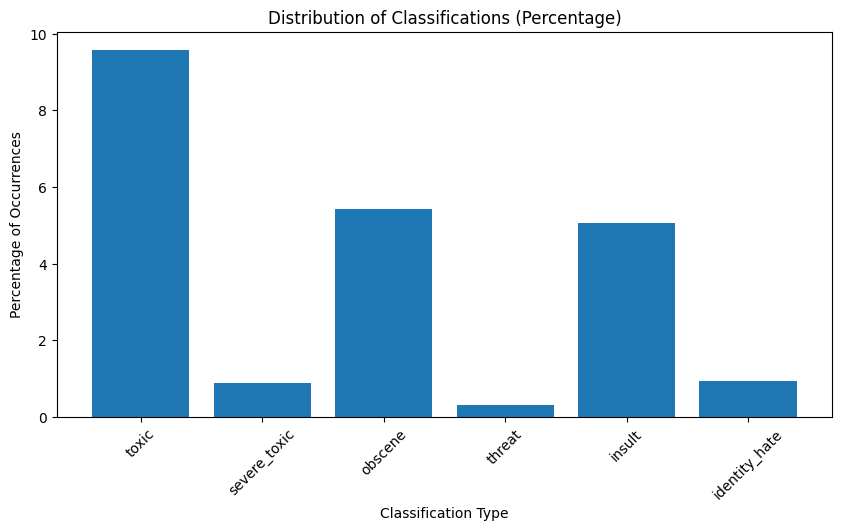

In [12]:
plot_percentages(classification_counts, ids_count)

## Preprocess dataset

Sample the data with **at least** a sample_size for each column in classification_columns  
Including a sample with rows where all classification_columns are 0   

### Balance dataset

In [ ]:
def balance_dataset(df: DataFrame, classification_columns: List, sample_size):

    sampled_dfs = []

    for col in classification_columns:
        temp_df = df[df[col] == 1].sample(sample_size)
        sampled_dfs.append(temp_df)

    all_zeroes_df = df[(df[classification_columns] == 0).all(axis=1)].sample(sample_size)
    sampled_dfs.append(all_zeroes_df)

    balanced_df = bpd.concat(sampled_dfs) # could create duplicates, dropping for simplicity
    balanced_df.drop_duplicates()
    
    return balanced_df

In [ ]:
SAMPLE_SIZE = 20

In [ ]:
balanced_data = balance_dataset(df, classification_columns, sample_size = SAMPLE_SIZE)

In [ ]:
def plot_distribution(classification_counts: DataFrame):

    plt.figure(figsize=(10, 5))
    plt.bar(classification_counts.index, classification_counts.values)
    plt.title('Distribution of Classifications')
    plt.xlabel('Classification Type')
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
balanced_data_counts = balanced_data[classification_columns].sum()
balanced_data_counts

In [18]:
total = balanced_data["id"].count()
print(f"Total: {total}")

Total: 140


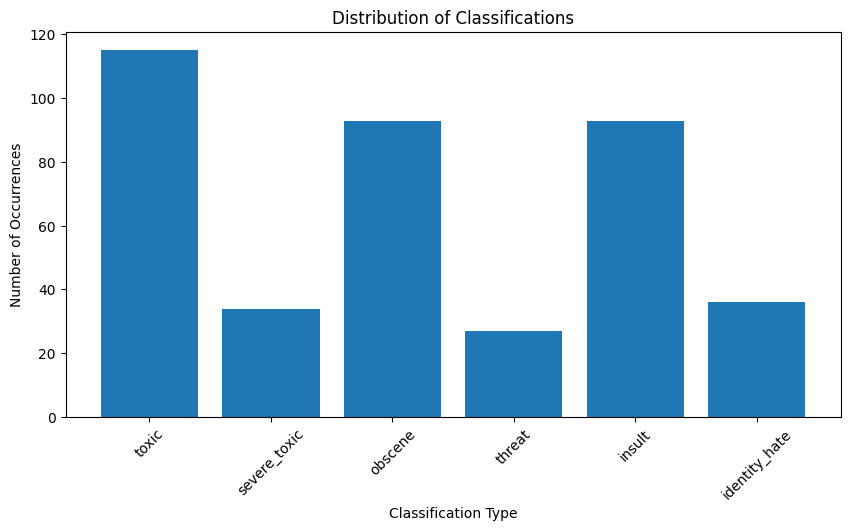

In [19]:
plot_distribution(balanced_data_counts)

### Split dataset

In [ ]:
train_df, test_df = train_test_split(balanced_data, test_size=0.2, random_state=42)

In [21]:
print("Training data sample size: ", train_df["id"].count())
print("Test data sample size: ", test_df["id"].count())

Training data sample size:  112
Test data sample size:  28


#### Persist this transformed data to BigQuery to simplify the execution graph

In [ ]:
train_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_train_dataset", if_exists="replace")
test_df.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_test_dataset", if_exists="replace")

In [ ]:
train_dataset = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_train_dataset")
test_dataset = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_test_dataset")

## Configure Gemini

In [ ]:
system_instructions = [
    """You are a Responsible AI specialist, and analysis harmful content with the objective of filtering such undesired content from the web via your analysis""",
    """You will respond only 0s or 1s in JSON format to the following fields: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate" """
]

In [ ]:
class ResponseSchema(BaseModel):
    toxic: int
    severe_toxic: int
    obscene: int
    threat: int
    insult: int
    identity_hate: int

In [ ]:
prompt = """
Your task is to analyze comments from the web and classify if the content is related to the following classifications: "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
Here is the comment you should analyze and generate the structured response with the classifications: 
"""

In [ ]:
def predict(prompt, model_name, max_retries=5, initial_delay=2):

    import time
    from google import genai
    from google.genai import types

    client = genai.Client(
      vertexai=True,
      project=PROJECT_ID,
      location="us-central1"
    )

    model = model_name

    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(prompt)
            ]
        )
    ]

    generate_content_config = types.GenerateContentConfig(
        temperature = 0.5,
        max_output_tokens = 128,
        response_mime_type = "application/json",
        response_schema = ResponseSchema,
        safety_settings = [types.SafetySetting(
            category = 'HARM_CATEGORY_UNSPECIFIED',
            threshold = 'BLOCK_ONLY_HIGH',
        )],
        system_instruction = system_instructions,
    )
    
    retries, delay = 0, initial_delay
    while retries <= max_retries:
        try:
            response = client.models.generate_content(model=model,
                                                      contents=contents,
                                                      config=generate_content_config)
            return response.text
        except Exception:
            if retries == max_retries:
                return
            time.sleep(delay)
            delay *= 2
            retries += 1
    return

In [ ]:
@bpd.remote_function(
    [str, str],
    str,
    bigquery_connection=CONNECTION_ID,
    packages=["google-genai"]
)
def generate_predictions(prompt: str, model_name: str) -> str:
    
    prediction = predict(prompt, model_name)
    
    return prediction

## Run predictions against the test dataset using Gemini 2.0 (default)

In [ ]:
GEMINI_MODEL = "gemini-2.0-flash-exp"

In [ ]:
test_dataset["input_prompt"] = prompt + test_dataset["comment_text"]

In [ ]:
input_remote_function = test_dataset[["input_prompt"]].assign(model_name=GEMINI_MODEL)

In [ ]:
predictions = test_dataset.assign(pred=input_remote_function.apply(generate_predictions, axis=1))

#### Persist this transformed data to BigQuery to simplify the execution graph

In [ ]:
predictions.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_raw", if_exists="replace")

### Extract attributes

In [ ]:
extract_query = f"CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.toxicity_predictions AS (SELECT *, " + "".join([f"CAST(JSON_EXTRACT(pred, '$.{col}') AS INT64) AS predicted_{col}," for col in classification_columns]) + f" FROM {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_raw)"

In [ ]:
%%bigquery
$extract_query

In [ ]:
toxicity_predictions = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions", use_cache=False)

In [37]:
toxicity_predictions.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,pred,predicted_toxic,predicted_severe_toxic,predicted_obscene,predicted_threat,predicted_insult,predicted_identity_hate
0,fc84b525b96f5bc5,No he really is a stinking gay rights activist...,1,0,0,0,1,1,Your task is to analyze comments from the web...,"{ ""identity_hate"": 1, ""insult"": 1, ""obscene"": ...",1,1,0,0,1,1
1,e19367f9304454eb,""" :There may be POV issues with showing an ...",0,0,0,0,0,0,Your task is to analyze comments from the web...,"{ ""identity_hate"": 0, ""insult"": 0, ""obscene""...",0,0,0,0,0,0
2,6fe2b7e3904620a0,== Fair and righteous opinion == You are a ...,1,1,1,0,1,1,Your task is to analyze comments from the web...,"{ ""identity_hate"": 1, ""insult"": 1, ""obscene"": ...",1,1,1,1,1,1
3,4728162570943035,:Addendum: I have just returned to find my Use...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{ ""identity_hate"": 0, ""insult"": 1, ""obscene"": ...",1,0,1,0,1,0
4,dc3221f167a7d3f3,- I agree with the specific conditions.,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{ ""identity_hate"": 0, ""insult"": 0, ""obscene"": ...",0,0,0,0,0,0


### Evaluate results

In [ ]:
def compute_recall_scores(predictions: DataFrame):

    recall_scores = {}

    for col in classification_columns:
        
        y_true = predictions[col]
        y_pred = predictions["predicted_" + col]
        
        recall_score = metrics.recall_score(y_true, y_pred, average=None)
        recall_scores[col] = recall_score.to_dict()
    
    return recall_scores

In [ ]:
recall_scores = compute_recall_scores(toxicity_predictions)

In [40]:
recall_scores

{'toxic': {0: 0.75, 1: 0.95},
 'severe_toxic': {0: 0.5714285714285714, 1: 0.7142857142857143},
 'obscene': {0: 0.9090909090909091, 1: 0.8823529411764706},
 'threat': {0: 0.9545454545454546, 1: 1.0},
 'insult': {0: 0.6363636363636364, 1: 1.0},
 'identity_hate': {0: 0.9047619047619048, 1: 0.7142857142857143}}

In [ ]:
def compute_precision_scores(predictions: DataFrame):

    precision_scores = {}

    for col in classification_columns:
        
        y_true = predictions[col]
        y_pred = predictions["predicted_" + col]
        
        precision_score = metrics.precision_score(y_true, y_pred, average=None)
        precision_scores[col] = precision_score.to_dict()
    
    return precision_scores

In [ ]:
precision_scores = compute_precision_scores(toxicity_predictions)

In [43]:
precision_scores

{'toxic': {0: 0.8571428571428571, 1: 0.9047619047619048},
 'severe_toxic': {0: 0.8571428571428571, 1: 0.35714285714285715},
 'obscene': {0: 0.8333333333333334, 1: 0.9375},
 'threat': {0: 1.0, 1: 0.8571428571428571},
 'insult': {0: 1.0, 1: 0.8095238095238095},
 'identity_hate': {0: 0.9047619047619048, 1: 0.7142857142857143}}

In [ ]:
def compute_f1_scores(predictions: DataFrame):

    f1_scores = {}

    for col in classification_columns:
        
        y_true = predictions[col]
        y_pred = predictions["predicted_" + col]
        
        f1_score = metrics.f1_score(y_true, y_pred, average=None)
        f1_scores[col] = f1_score.to_dict()
    
    return f1_scores

In [ ]:
f1_scores = compute_f1_scores(toxicity_predictions)

In [46]:
f1_scores

{'toxic': {0: 0.7999999999999999, 1: 0.9268292682926829},
 'severe_toxic': {0: 0.6857142857142857, 1: 0.4761904761904762},
 'obscene': {0: 0.8695652173913043, 1: 0.9090909090909091},
 'threat': {0: 0.9767441860465117, 1: 0.923076923076923},
 'insult': {0: 0.7777777777777778, 1: 0.8947368421052632},
 'identity_hate': {0: 0.9047619047619048, 1: 0.7142857142857143}}

## Finetune Gemini

#### Generate a dataset for fine-tuning

In [ ]:
def generate_fine_tuning_dataset(df: DataFrame) -> pd.DataFrame:
    
    df["input_prompt"] = prompt + df["comment_text"]
    fine_tuning_dataset = df.to_pandas()
    fine_tuning_dataset['expected_model_output'] = fine_tuning_dataset[classification_columns].apply(lambda row: row.to_json(), axis=1) 
    
    return fine_tuning_dataset

In [ ]:
fine_tuning_dataset_train = generate_fine_tuning_dataset(train_dataset)
fine_tuning_dataset_val = generate_fine_tuning_dataset(test_dataset)

In [49]:
fine_tuning_dataset_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,expected_model_output
0,97003050132a4384,FUCK YOU DICK LICKS! You guys will never be ...,1,1,1,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
1,d837f49721876ad9,EL OH FUCKING EL. NIGGER YOU THINK YOUR FUNNY....,1,1,1,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
2,71231d24cd28a682,Get off your fucking high horse. I'm not a new...,1,1,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
3,6a6c06ac54c01f31,look here your a fuckin cunt you czeckoslova...,1,1,1,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
4,286bcad31c36d1d3,sonek put princes saly in sonek 4 or clay al...,1,0,0,1,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
...,...,...,...,...,...,...,...,...,...,...
107,cdbcc8d96aabb699,stop grinning u idiot. What I said waz true t...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
108,8cd53f0520fb3bdc,You are an arse! SHUTUP!,1,0,0,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
109,c9640ae6ae7bb052,you have been blocked for being a pimped out f...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
110,eca0e12c9c0311cd,===Apology=== I would like to sincerely apol...,1,1,1,1,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."


In [50]:
fine_tuning_dataset_val

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_prompt,expected_model_output
0,83bda5fa72211a52,:::you can't get no satisfaction and the artic...,0,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
1,2f784baa117cfef7,"""well wat i think of halo 4 is the best game e...",1,0,0,0,0,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
2,fc84b525b96f5bc5,No he really is a stinking gay rights activist...,1,0,0,0,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":0,""threa..."
3,79412a691165763d,fuck this motherfucker asshole This asshole ...,1,1,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
4,4728162570943035,:Addendum: I have just returned to find my Use...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
5,a96dbeef4bb6b1be,Contd scoundrel the block on padmalskhmi was...,0,0,0,1,1,0,Your task is to analyze comments from the web...,"{""toxic"":0,""severe_toxic"":0,""obscene"":0,""threa..."
6,779a3066bb1bf2d7,Fuck you people are dumb.... Facebook IS a pub...,1,0,1,0,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
7,57f9d99c423cfa09,thanks for deleting my page you fucking cock s...,1,1,1,1,1,0,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."
8,faebd256d585a0ee,Mexican dickhead You and your family should...,1,0,1,1,1,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":0,""obscene"":1,""threa..."
9,2a2805dc384e9b60,"Also, I Ohnoitsjamie am a homosexual who likes...",1,1,1,0,0,1,Your task is to analyze comments from the web...,"{""toxic"":1,""severe_toxic"":1,""obscene"":1,""threa..."


In [ ]:
def generate_records(df: pd.DataFrame, system_instructions: List) -> List:
    
    records = []

    for index, row in df.iterrows():

        input_prompt = row['input_prompt']
        expected_model_output = row['expected_model_output']

        record = {
          "systemInstruction": {
            "role": "system",
            "parts": [ { "text": system_instruction } for system_instruction in system_instructions ]
          },
          "contents": [
            { "role": "user", "parts": [ { "text": input_prompt } ] },
            { "role": "model", "parts": [ { "text": expected_model_output } ] } ] 
        }

        records.append(record)
        
    return records

In [ ]:
train_records = generate_records(fine_tuning_dataset_train, system_instructions)
val_records = generate_records(fine_tuning_dataset_val, system_instructions)

In [53]:
print("Fine-tuning train dataset size: ", len(train_records))
print("Fine-tuning validation dataset size: ", len(val_records))

Fine-tuning train dataset size:  112
Fine-tuning validation dataset size:  28


#### Upload to GCS

In [ ]:
BUCKET_NAME = "<BUCKET_NAME>"

TRAIN_FILE_NAME = "fine-tuning-train-dataset.jsonl"
VAL_FILE_NAME = "fine-tuning-val-dataset.jsonl"

In [ ]:
def upload_gcs(records: List, file_name: str, bucket_name: str = BUCKET_NAME, project_id: str = PROJECT_ID) -> str:
    
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_name)

    jsonl_data = "\n".join(json.dumps(item) for item in records)
    blob.upload_from_string(jsonl_data)
    
    uri = f"gs://{bucket_name}/{file_name}"

    return uri

In [ ]:
uri_train = upload_gcs(train_records, TRAIN_FILE_NAME)
uri_val = upload_gcs(val_records, VAL_FILE_NAME)

#### Run Vertex AI Supervised Fine Tuning job

In [ ]:
client = genai.Client(
    vertexai=True,
    project=PROJECT_ID,
    location="us-central1"
)

In [ ]:
GEMINI_MODEL = "gemini-1.5-pro-002" # Gemini 2.0 still does not suport SFT

In [ ]:
tuning_job = client.tunings.tune(
    base_model = GEMINI_MODEL,
    training_dataset = types.TuningDataset(gcs_uri = uri_train),
    config=types.CreateTuningJobConfig(
        epoch_count= 8,
        tuned_model_display_name="tuned_gemini_1_5_pro",
        adapter_size = "ADAPTER_SIZE_FOUR",
        learning_rate_multiplier = 0.8,
        validation_dataset = types.TuningDataset(gcs_uri = uri_val)
    )
)

In [ ]:
while not tuning_job.has_ended:
    time.sleep(30)
    tuning_job = client.tunings.get(name=tuning_job.name)

In [ ]:
print(tuning_job.tuned_model.model)
print(tuning_job.tuned_model.endpoint)
print(tuning_job.experiment)

## Run predictions against the test dataset using Gemini (fine-tuned)

In [ ]:
input_remote_function_tuned = test_dataset[["input_prompt"]].assign(model_name=tuning_job.tuned_model.endpoint)

In [ ]:
predictions_tuned = test_dataset.assign(pred=input_remote_function_tuned.apply(generate_predictions, axis=1))

In [ ]:
predictions_tuned.to_gbq(destination_table=f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned_raw", if_exists="replace")

In [ ]:
extract_query = f"CREATE OR REPLACE TABLE {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned AS (SELECT *, " + "".join([f"CAST(JSON_EXTRACT(pred, '$.{col}') AS INT64) AS predicted_{col}," for col in classification_columns]) + f" FROM {PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned_raw)"

In [ ]:
%%bigquery
$extract_query

In [ ]:
toxicity_predictions_tuned = bpd.read_gbq(f"{PROJECT_ID}.{DATASET_ID}.toxicity_predictions_finetuned", use_cache=False)

### Evaluate results

In [ ]:
recall_scores_tuned = compute_recall_scores(toxicity_predictions_tuned)

In [87]:
recall_scores_tuned

{'toxic': {0: 0.875, 1: 0.9},
 'severe_toxic': {0: 0.8095238095238095, 1: 0.5714285714285714},
 'obscene': {0: 0.8181818181818182, 1: 0.9411764705882353},
 'threat': {0: 0.8636363636363636, 1: 1.0},
 'insult': {0: 0.8181818181818182, 1: 0.9411764705882353},
 'identity_hate': {0: 0.8571428571428571, 1: 0.7142857142857143}}

In [ ]:
precision_scores_tuned = compute_precision_scores(toxicity_predictions_tuned)

In [89]:
precision_scores_tuned

{'toxic': {0: 0.7777777777777778, 1: 0.9473684210526315},
 'severe_toxic': {0: 0.85, 1: 0.5},
 'obscene': {0: 0.9, 1: 0.8888888888888888},
 'threat': {0: 1.0, 1: 0.6666666666666666},
 'insult': {0: 0.9, 1: 0.8888888888888888},
 'identity_hate': {0: 0.9, 1: 0.625}}

In [ ]:
f1_scores_tuned = compute_f1_scores(toxicity_predictions_tuned)

In [91]:
f1_scores_tuned

{'toxic': {0: 0.823529411764706, 1: 0.9230769230769231},
 'severe_toxic': {0: 0.8292682926829269, 1: 0.5333333333333333},
 'obscene': {0: 0.8571428571428572, 1: 0.9142857142857143},
 'threat': {0: 0.9268292682926829, 1: 0.8},
 'insult': {0: 0.8571428571428572, 1: 0.9142857142857143},
 'identity_hate': {0: 0.8780487804878048, 1: 0.6666666666666666}}

## Prediction results difference between Gemini vs Gemini Fine Tuned

In [ ]:
def plot_differences(title, gemini_scores, gemini_finetuned_scores):
    
    categories = list(gemini_scores.keys())
    
    gemini_scores = [np.mean(list(v.values())) for v in gemini_scores.values()]
    gemini_finetuned_scores = [np.mean(list(v.values())) for v in gemini_finetuned_scores.values()]

    differences = [m1 - m2 for m1, m2 in zip(gemini_scores, gemini_finetuned_scores)] 

    bar_width = 0.35
    index = np.arange(len(categories))

    fig, ax = plt.subplots()
    rects1 = ax.bar(index, gemini_scores, bar_width, label='Gemini 2.0')
    rects2 = ax.bar(index + bar_width, gemini_finetuned_scores, bar_width, label='Gemini 1.5 Fine Tuned')

    ax.set_xlabel('Classification')
    ax.set_ylabel('Score value')
    ax.set_title(title)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    fig.tight_layout()
    plt.show()

#### Precision Score

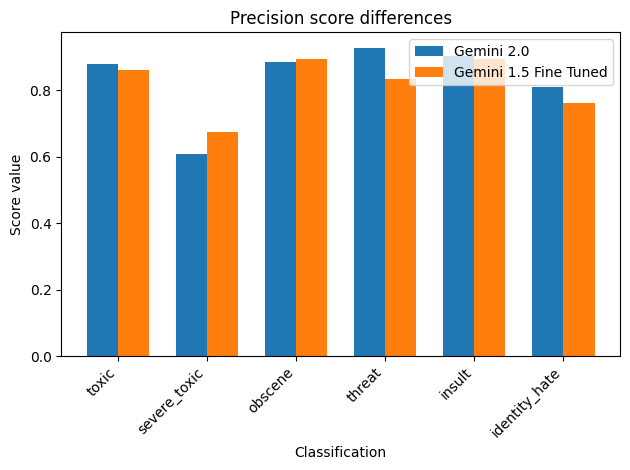

In [93]:
plot_differences("Precision score differences", precision_scores, precision_scores_tuned)

#### Recall Score

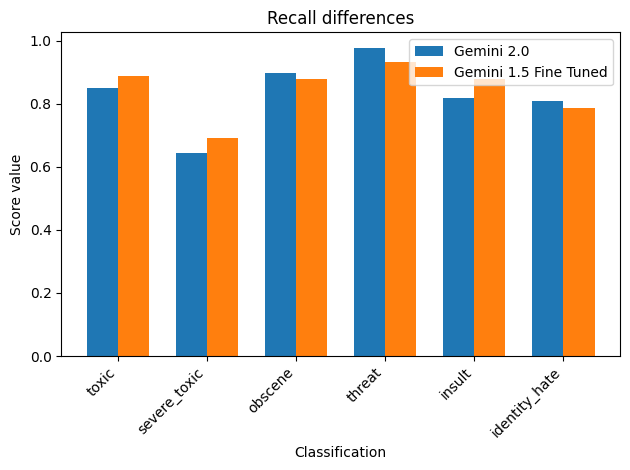

In [95]:
plot_differences("Recall differences", recall_scores, recall_scores_tuned)

#### F1 Score

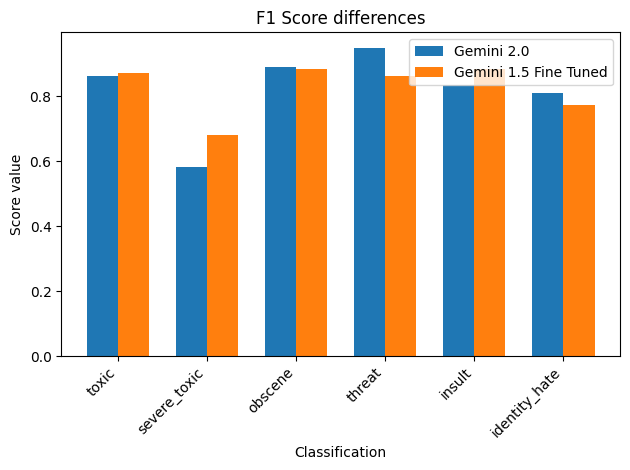

In [94]:
plot_differences("F1 Score differences", f1_scores, f1_scores_tuned)